In [29]:
import numpy as np
import copy
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def interval_count(curr, max_val, step, count):
    if curr >= max_val:
        return count
    else:
        if step(curr) <= 0:
            raise RuntimeError("Step function returns non-positive value in range")
        return interval_count(curr + step(curr), max_val, step, count + 1)

In [4]:
#This takes in the following data types:
# - x_min, x_max, y_min, y_max, z_min, z_max: Either a tuple (position, f(x_1, x_2)), where position is the x, y or z value of the side and the min value is less than the max val and 
#       f(x_1, x_2) is a function for the potential on that surface in terms of the other 2 variables, or a Nonetype value, representing a side going off to infinity. 
#       if and sides going of to infinity are used, it's recommended that a log scale be used for that coordinate
# - x_interval, y_interval, z_interval: These are functions that take in a real number and return a positive number in the range [v_min, v_max] for v=x,y,z. 
#       For a given value this function returns how far away in the correpsponding cartesian coordinate the next data point is, meaning if you want more points in one area, the interval
#       functions should return a smaller positive value in that area. Default values are functions that return 1, giving uniform scaling.
# - inf_val: this is a number of some kind, and represents the arbitrarily large number used to model an infinite side, default value is 100. 
#       NOTE: if you go higher than you may run into runtime issues
def init_space(x_min, x_max, y_min, y_max, z_min, z_max, x_interval = lambda x: 1, y_interval = lambda y: 1, z_interval = lambda z: 1, inf_val = 100):
    inf = (inf_val, lambda v, w: 0)
    m_inf = (-inf_val, lambda v, w:0)
    if x_min == None: x_min = m_inf
    if x_max == None: x_max = inf
    if y_min == None: y_min = m_inf
    if y_max == None: y_max = inf
    if z_min == None: z_min = m_inf
    if z_max == None: z_max = inf

    valnet = np.zeros((interval_count(x_min[0], x_max[0], x_interval, 1),
                      interval_count(y_min[0], y_max[0], y_interval, 1), 
                      interval_count(z_min[0], z_max[0], z_interval, 1)))
    
    posnet = np.zeros((interval_count(x_min[0], x_max[0], x_interval, 1),
                      interval_count(y_min[0], y_max[0], y_interval, 1), 
                      interval_count(z_min[0], z_max[0], z_interval, 1), 3))
    
    space = {"position": np.copy(posnet), "value": np.copy(valnet)}
    
    #Set the position vectors
    for x in range(len(space["position"])):
        for y in range(len(space["position"][0])):
            for z in range(len(space["position"][0, 0])):
                x_val = x_min[0] if x==0 else min(space["position"][x-1, y, z, 0] + x_interval(space["position"][x-1, y, z, 0]), x_max[0])
                y_val = y_min[0] if y==0 else min(space["position"][x, y-1, z, 1] + y_interval(space["position"][x, y-1, z, 1]), y_max[0])
                z_val = z_min[0] if z==0 else min(space["position"][x, y, z-1, 2] + z_interval(space["position"][x, y, z-1, 2]), z_max[0])
                space["position"][x, y, z] = [x_val, y_val, z_val]
                
    #Set x = x_min[0] and x=x_max[0] sides
    for y_i in range(len(space["position"][0])):
            for z_i in range(len(space["position"][0, 0])):
                space["value"][0, y_i, z_i] = x_min[1](space["position"][0, y_i, z_i, 1], space["position"][0, y_i, z_i, 2])
                space["value"][-1, y_i, z_i] = x_max[1](space["position"][-1, y_i, z_i, 1], space["position"][-1, y_i, z_i, 2])
                
    #Set y_min & y_max sides.
    #Note, this method of data storage means the edges and corners of the space get a bit funky because of overlap, but that's fine since they aren't used for future calculations 
    #and are known values, so you don't need them to be exact.
    for x_i in range(len(space["position"])):
        for z_i in range(len(space["position"][0, 0])):
            space["value"][x_i, 0, z_i] = y_min[1](space["position"][x_i, 0, z_i, 0], space["position"][x_i, 0, z_i, 2])
            space["value"][x_i, -1, z_i] = y_max[1](space["position"][x_i, -1, z_i, 0], space["position"][x_i, -1, z_i, 2])
            
    #Set z_min & z_max sides
    for x_i in range(len(space["position"])):
        for y_i in range(len(space["position"][0])):
            space["value"][x_i, y_i, 0] = z_min[1](space["position"][x_i, y_i, 0, 0], space["position"][x_i, y_i, 0, 1])
            space["value"][x_i, y_i, -1] = z_max[1](space["position"][x_i, y_i, -1, 0], space["position"][x_i, y_i, -1, 1])
            
    return space

In [5]:
#This is the actual method where the relaxation is done, it's nice and simple thanks to recursion! Just give it a space (generated by the above function), and the number of 
#Passes to go over this with the relaxation algorithm
def relax_space(space, count):
    if count==0: return space
    temp = copy.deepcopy(space)
    for x in range(1, len(space["position"])-1):
        for y in range(1, len(space["position"][0])-1):
            for z in range(1, len(space["position"][0, 0])-1):
                average = (space["value"][x - 1, y, z] + space["value"][x + 1, y, z] + 
                           space["value"][x, y - 1, z] + space["value"][x, y + 1, z] + 
                           space["value"][x, y, z - 1] + space["value"][x, y, z + 1])/6
                
                temp["value"][x, y, z] = average
    return relax_space(temp, count - 1)

In [6]:
#This is a function that returns the index of a given position vector since non-uniform scaling can make it hard to find otherwise.
def find_position(space, r):
    min_dist = None
    min_index = None
    for x in range(len(space["position"])):
        for y in range(len(space["position"][x])):
            for z in range(len(space["position"][x, y])):
                dist = np.linalg.norm(r-space["position"][x, y, z])
                if min_dist == None or dist < min_dist:
                    min_dist = dist
                    min_index = [x, y, z]
    return min_index

In [7]:
#This is a function that returns the average error of the relaxation function compared to a given function.
def find_error(space, func):
    tot_dist = 0
    count = 0
    for x in range(1, len(space["position"])-1):
        for y in range(1, len(space["position"][x])-1):
            for z in range(1, len(space["position"][x, y])-1):
                dist = space["value"][x,y,z]-func(x, y, z)
                tot_dist +=dist
                count +=1
    return tot_dist/count

In [165]:
#This takes a space and 3 variables to graph, 2 of which are True, which indicates that is one of the 2 values you want to graph it for, and the last one is a constant, representing the 
#index of the 3rd variable you want to be constant, and angle is the view angle
#x_min, x_max, y_min and etc. are the minimum and maximum indices of data you want to visualize, so you can restrict what area you show

def space_plot(space, x, y, z, angle = 30, x_min = 0, x_max = None, y_min = 0, y_max = None, z_min = 0, z_max = None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    if x_max == None: x_max = len(space["position"])
    if y_max == None: y_max = len(space["position"][0])
    if z_max == None: z_max = len(space["position"][0, 0])
    
    
    x_series = []
    y_series = []
    z_series = []
    result_series = None
    for x_i in range(x_min, x_max):
        x_series.append(space["position"][x_i, 0, 0, 0])
        
    for y_i in range(y_min, y_max):
        y_series.append(space["position"][0, y_i, 0, 1])
        
    for z_i in range(z_min, z_max):
        z_series.append(space["position"][0, 0, z_i, 2])
        
    if type(x)==type(y):
        result_series = np.zeros((len(y_series), len(x_series)))
        x_series, y_series = np.meshgrid(x_series, y_series)
        
        for x_i in range(x_min, x_max):
            for y_i in range(y_min, y_max):
                result_series[y_i,x_i] = space["value"][x_i, y_i, z]
        surf = ax.plot_surface(x_series, y_series, result_series, cmap="coolwarm")
                
    if type(x)==type(z):
        result_series = np.zeros((len(z_series), len(x_series)))
        x_series, z_series = np.meshgrid(x_series, z_series)
        
        for x_i in range(x_min, x_max):
            for z_i in range(z_min, z_max):
                result_series[z_i,x_i] = space["value"][x_i, y, z_i]
        surf = ax.plot_surface(x_series, z_series, result_series, cmap="coolwarm")
        
    if type(y)==type(z):
        result_series = np.zeros((len(z_series), len(y_series)))
        y_series, z_series = np.meshgrid(y_series, z_series)
        
        for y_i in range(y_min, y_max):
            for z_i in range(z_min, z_max):
                result_series[z_i,y_i] = space["value"][x, y_i, z_i]
        surf = ax.plot_surface(y_series, z_series, result_series, cmap="coolwarm")
    

In [123]:
def test_func(x, y):
    return 6/np.pi*np.arctan(np.sin(np.pi*y/10)/np.sinh(np.pi*x/10))

In [117]:
test = init_space(None, None ,(0, lambda x,z: 0), (10, lambda x,y: 0), (0, lambda x,y: 3), None, x_interval = lambda x: np.exp(abs(x)/500), z_interval = lambda z: np.exp(abs(z)/500))
t1 = dt.datetime.now()
result = relax_space(test, 500)
print("Done in " + str(dt.datetime.now() - t1))

Done in 0:03:24.829137


In [13]:
find_error(result, test_func)

-0.0014846344227468422

In [141]:
result["value"][91]

array([[3.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 1.46823403e+00, 8.45789770e-01, ...,
        3.28378138e-15, 1.42900716e-15, 0.00000000e+00],
       [3.00000000e+00, 2.02714645e+00, 1.37345096e+00, ...,
        6.24612335e-15, 2.71813314e-15, 0.00000000e+00],
       ...,
       [3.00000000e+00, 2.02714645e+00, 1.37345096e+00, ...,
        6.24612335e-15, 2.71813314e-15, 0.00000000e+00],
       [3.00000000e+00, 1.46823403e+00, 8.45789770e-01, ...,
        3.28378138e-15, 1.42900716e-15, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

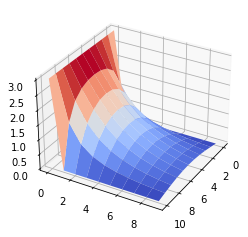

In [171]:
space_plot(result, 91, True, True, angle = 30, z_max = 10)

<ipython-input-123-c95bca1720bb>:2: RuntimeWarning: divide by zero encountered in true_divide
  return 6/np.pi*np.arctan(np.sin(np.pi*y/10)/np.sinh(np.pi*x/10))


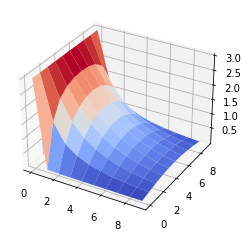

In [173]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 10, 1)
Y = np.arange(0.01, 10, 1)
X, Y = np.meshgrid(X, Y)
Z = test_func(X,Y)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap="coolwarm")